# 3. Indexes

## Data

In [1]:
%matplotlib inline

import datetime
import glob
import json
from io import StringIO

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

# States are broken into networks. The networks have a list of ids, each representing a station.
# We will take that list of ids and pass them as query parameters to the URL we built up ealier.
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# IEM has Iowa AWOS sites in its own labeled network
networks = ["AWOS"] + ["{}_ASOS".format(state) for state in states]

In [7]:
def get_weather(
    stations, start=pd.Timestamp("2014-01-01"), end=pd.Timestamp("2014-01-31")
):
    """
    Fetch weather data from MESONet between ``start`` and ``stop``.
    """
    url = (
        "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
        "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=vsby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
        "&tz=Etc/UTC&format=comma&latlon=no"
        "&{start:year1=%Y&month1=%m&day1=%d}"
        "&{end:year2=%Y&month2=%m&day2=%d}&{stations}"
    )
    stations = "&".join("station=%s" % s for s in stations)
    weather = (
        pd.read_csv(url.format(start=start, end=end, stations=stations), comment="#")
        .rename(columns={"valid": "date"})
        .rename(columns=str.strip)
        .assign(date=lambda df: pd.to_datetime(df["date"]))
        .set_index(["station", "date"])
        .sort_index()
    )
    float_cols = ["tmpf", "relh", "sped", "mslp", "p01i", "vsby", "gust_mph"]
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="coerce")
    return weather


def get_ids(network):
    url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
    r = requests.get(url.format(network))
    md = pd.json_normalize(r.json()["features"])
    md["network"] = network
    return md

## `json_normalize`

In [3]:
url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
r = requests.get(url.format("AWOS"))
js = r.json()
js["features"][:2]

[{'type': 'Feature',
  'id': 'AXA',
  'properties': {'elevation': 368.8,
   'sname': 'ALGONA',
   'state': 'IA',
   'country': 'US',
   'climate_site': 'IA0133',
   'wfo': 'DMX',
   'tzname': 'America/Chicago',
   'ncdc81': 'USC00130133',
   'ugc_county': 'IAC109',
   'ugc_zone': 'IAZ005',
   'county': 'Kossuth',
   'sid': 'AXA'},
  'geometry': {'type': 'Point', 'coordinates': [-94.2724, 43.0796]}},
 {'type': 'Feature',
  'id': 'IKV',
  'properties': {'elevation': 270.7,
   'sname': 'ANKENY',
   'state': 'IA',
   'country': 'US',
   'climate_site': 'IA0241',
   'wfo': 'DMX',
   'tzname': 'America/Chicago',
   'ncdc81': 'USC00130241',
   'ugc_county': 'IAC153',
   'ugc_zone': 'IAZ060',
   'county': 'Polk',
   'sid': 'IKV'},
  'geometry': {'type': 'Point', 'coordinates': [-93.5695, 41.6878]}}]

This won't work

In [4]:
pd.DataFrame(js["features"]).head()

,type,id,properties,geometry
0,Feature,AXA,"{'elevation': 368.8, 'sname': 'ALGONA', 'state...","{'type': 'Point', 'coordinates': [-94.2724, 43..."
1,Feature,IKV,"{'elevation': 270.7, 'sname': 'ANKENY', 'state...","{'type': 'Point', 'coordinates': [-93.5695, 41..."
2,Feature,AIO,"{'elevation': 351.7, 'sname': 'ATLANTIC', 'sta...","{'type': 'Point', 'coordinates': [-95.0465, 41..."
3,Feature,ADU,"{'elevation': 399.3, 'sname': 'AUDUBON', 'stat...","{'type': 'Point', 'coordinates': [-94.9204, 41..."
4,Feature,BNW,"{'elevation': 349.3, 'sname': 'BOONE MUNI', 's...","{'type': 'Point', 'coordinates': [-93.8486, 42..."


Use `json_normalize`

In [5]:
pd.json_normalize(js['features']).head()

,type,id,properties.elevation,properties.sname,properties.state,properties.country,properties.climate_site,properties.wfo,properties.tzname,properties.ncdc81,properties.ugc_county,properties.ugc_zone,properties.county,properties.sid,geometry.type,geometry.coordinates
0,Feature,AXA,368.8,ALGONA,IA,US,IA0133,DMX,America/Chicago,USC00130133,IAC109,IAZ005,Kossuth,AXA,Point,"[-94.2724, 43.0796]"
1,Feature,IKV,270.7,ANKENY,IA,US,IA0241,DMX,America/Chicago,USC00130241,IAC153,IAZ060,Polk,IKV,Point,"[-93.5695, 41.6878]"
2,Feature,AIO,351.7,ATLANTIC,IA,US,IA0364,DMX,America/Chicago,USC00130364,IAC029,IAZ070,Cass,AIO,Point,"[-95.0465, 41.4059]"
3,Feature,ADU,399.3,AUDUBON,IA,US,IA0385,DMX,America/Chicago,USC00130385,IAC009,IAZ057,Audubon,ADU,Point,"[-94.9204, 41.6994]"
4,Feature,BNW,349.3,BOONE MUNI,IA,US,IA0807,DMX,America/Chicago,USC00130807,IAC015,IAZ047,Boone,BNW,Point,"[-93.8486, 42.0486]"


In [8]:
import os

ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)
gr = ids.groupby("network")

store = "data/weather.h5"

if not os.path.exists(store):
    os.makedirs("data/weather", exist_ok=True)

    for k, v in gr:
        weather = get_weather(v["id"])
        weather.to_csv("data/weather/{}.csv".format(k))

    weather = pd.concat(
        [
            pd.read_csv(f, parse_dates=["date"], index_col=["station", "date"])
            for f in glob.glob("data/weather/*.csv")
        ]
    ).sort_index()

    weather.to_hdf("data/weather.h5", "weather")
else:
    weather = pd.read_hdf("data/weather.h5", "weather")

/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
weather.head()

tmpf   relh  sped  mslp  p01i  vsby  gust_mph  \
station date                                                                  
01M     2014-01-01 00:15:00  33.80  85.86   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:35:00  33.44  87.11   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 00:55:00  32.54  90.97   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:15:00  31.82  93.65   0.0   NaN   0.0  10.0       NaN   
        2014-01-01 01:35:00  32.00  92.97   0.0   NaN   0.0  10.0       NaN   

                            skyc1 skyc2 skyc3  
station date                                   
01M     2014-01-01 00:15:00   CLR     M     M  
        2014-01-01 00:35:00   CLR     M     M  
        2014-01-01 00:55:00   CLR     M     M  
        2014-01-01 01:15:00   CLR     M     M  
        2014-01-01 01:35:00   CLR     M     M

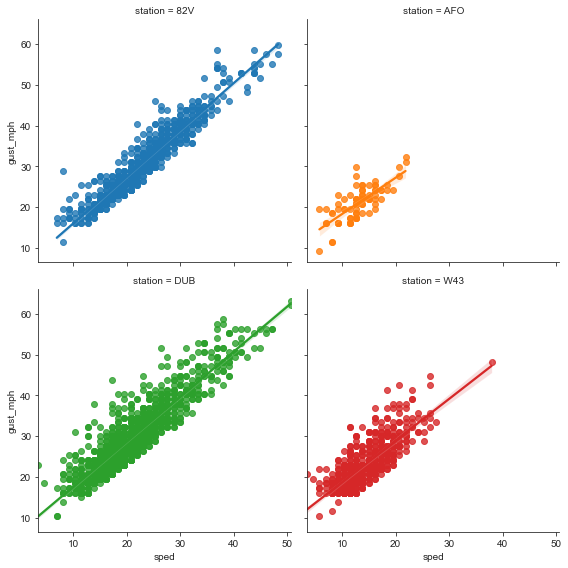

In [11]:
airports = ["W43", "AFO", "82V", "DUB"]
g = sns.FacetGrid(
    weather.loc[airports].reset_index(),
    col="station",
    hue="station",
    col_wrap=2,
    height=4,
)
g.map(sns.regplot, "sped", "gust_mph")

## Set operations

Find airports that have both weather and flight information.

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>MultiIndex.level</code></b> for grabbing specific indexes from a MultiIndex</li>
    <li><b><code>Index.difference</code></b> for finding indexes that exist in one set but not the other</li>
    <li><b><code>^</code></b> for symmetric differences</li>
</div>

In [90]:
flights = pd.read_hdf("data/flights.h5", "flights")
weather_locs = weather.index.levels[0]
# The `categories` attributes of a Categorical is an Index
origin_locs = flights.origin.cat.categories
dest_locs = flights.dest.cat.categories

airports = weather_locs & origin_locs & dest_locs
airports

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'AEX', 'AGS',
       ...
       'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'XNA'],
      dtype='object', length=265)

In [27]:
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')

print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')

print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Weather, no flights:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=1910)

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BQN', 'BRW', 'CDV', 'FAI', 'FCA', 'GUM',
       'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG', 'OME', 'OTZ',
       'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT', 'STX', 'WRG',
       'YAK', 'YUM'],
      dtype='object')

Dropped Stations:
	 Index(['01M', '04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=1942)


## Flavors

Pandas has multiple type of indexes:

1. `Index`
2. `Int64Index`
3. `RangeIndex` (Memory-saving special case of Int64Index)
4. `FloatIndex`
5. `DatetimeIndex`: Datetime64[ns] precision data
6. `PeriodIndex`: Regularly-spaced, arbitrary precision datetime data.
7. `TimedeltaIndex`: Timedelta data
8. `CategoricalIndex`:

Most of the time these are automatically created

### Row slicing

User row slicing for returning subset

In [46]:
# Using indexes
weather.loc["DSM"].head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2014-01-01 00:54:00,10.94,72.79,10.35,1024.9,0.0,10.0,NaN,FEW,M,M
2014-01-01 01:54:00,10.94,72.79,11.50,1025.4,0.0,10.0,NaN,OVC,M,M
2014-01-01 02:54:00,10.94,72.79,8.05,1025.3,0.0,10.0,NaN,BKN,M,M
2014-01-01 03:54:00,10.94,72.79,9.20,1025.3,0.0,10.0,NaN,OVC,M,M
2014-01-01 04:54:00,10.04,72.69,9.20,1024.7,0.0,10.0,NaN,BKN,M,M


In [48]:
# Not using indexes (harder)
weather2 = weather.reset_index()
weather2[weather2['station'] == 'DSM'].head()

,station,date,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
884855,DSM,2014-01-01 00:54:00,10.94,72.79,10.35,1024.9,0.0,10.0,NaN,FEW,M,M
884856,DSM,2014-01-01 01:54:00,10.94,72.79,11.50,1025.4,0.0,10.0,NaN,OVC,M,M
884857,DSM,2014-01-01 02:54:00,10.94,72.79,8.05,1025.3,0.0,10.0,NaN,BKN,M,M
884858,DSM,2014-01-01 03:54:00,10.94,72.79,9.20,1025.3,0.0,10.0,NaN,OVC,M,M
884859,DSM,2014-01-01 04:54:00,10.04,72.69,9.20,1024.7,0.0,10.0,NaN,BKN,M,M


### Indexes for easier arithmetic, analysis

Translate from Fahrenheit to Celsius.

In [49]:
# Using indexes
temp = weather["tmpf"]
c = (temp - 32) * 5 / 9
c.to_frame()

tmpf
station date                     
01M     2014-01-01 00:15:00   1.0
        2014-01-01 00:35:00   0.8
        2014-01-01 00:55:00   0.3
        2014-01-01 01:15:00  -0.1
        2014-01-01 01:35:00   0.0
...                           ...
ZZV     2014-01-30 19:53:00  -2.8
        2014-01-30 20:53:00  -2.2
        2014-01-30 21:53:00  -2.2
        2014-01-30 22:53:00  -2.8
        2014-01-30 23:53:00  -1.7

[3303647 rows x 1 columns]

In [50]:
# Not using indexes
temp2 = weather.reset_index()[["station", "date", "tmpf"]]
temp2["tmpf"] = (temp2["tmpf"] - 32) * 5 / 9
temp2.head()

,station,date,tmpf
0,01M,2014-01-01 00:15:00,1.0
1,01M,2014-01-01 00:35:00,0.8
2,01M,2014-01-01 00:55:00,0.3
3,01M,2014-01-01 01:15:00,-0.1
4,01M,2014-01-01 01:35:00,0.0


### Indexes for alignment

Let's create two DataFrame with different indexes

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>.div</code><b> for dividing two series while controlling axis and fill value for NaN</li>
</div>

In [53]:
dsm = weather.loc["DSM"]
hourly = dsm.resample("H").mean()
temp = hourly["tmpf"].sample(frac=0.5, random_state=1).sort_index()
sped = hourly["sped"].sample(frac=0.5, random_state=2).sort_index()
temp.head().to_frame()

,tmpf
date,
2014-01-01 00:00:00,10.94
2014-01-01 02:00:00,10.94
2014-01-01 03:00:00,10.94
2014-01-01 04:00:00,10.04
2014-01-01 05:00:00,10.04


In [54]:
sped.head()

date
2014-01-01 01:00:00    11.50
2014-01-01 02:00:00     8.05
2014-01-01 03:00:00     9.20
2014-01-01 04:00:00     9.20
2014-01-01 05:00:00    10.35
Name: sped, dtype: float64

Pandas will automatically align things due to index when performing operations

In [56]:
(sped / temp).to_frame()

,0
date,
2014-01-01 00:00:00,NaN
2014-01-01 01:00:00,NaN
2014-01-01 02:00:00,0.735832
2014-01-01 03:00:00,0.840951
2014-01-01 04:00:00,0.916335
...,...
2014-01-30 13:00:00,NaN
2014-01-30 14:00:00,0.590416
2014-01-30 17:00:00,NaN


Can also use `.div` to specify a fill value for the indexes that do not match

In [59]:
sped.div(temp, fill_value=1).to_frame()

,0
date,
2014-01-01 00:00:00,0.091408
2014-01-01 01:00:00,11.500000
2014-01-01 02:00:00,0.735832
2014-01-01 03:00:00,0.840951
2014-01-01 04:00:00,0.916335
...,...
2014-01-30 13:00:00,0.027809
2014-01-30 14:00:00,0.590416
2014-01-30 17:00:00,0.023267


Also can use `axis` parameter in `.div` to control alignment axis

In [60]:
hourly

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,10.94,72.79,10.35,1024.9,0.0,10.0,NaN
2014-01-01 01:00:00,10.94,72.79,11.50,1025.4,0.0,10.0,NaN
2014-01-01 02:00:00,10.94,72.79,8.05,1025.3,0.0,10.0,NaN
2014-01-01 03:00:00,10.94,72.79,9.20,1025.3,0.0,10.0,NaN
2014-01-01 04:00:00,10.04,72.69,9.20,1024.7,0.0,10.0,NaN
...,...,...,...,...,...,...,...
2014-01-30 19:00:00,30.92,55.99,28.75,1006.3,0.0,10.0,35.65
2014-01-30 20:00:00,30.02,55.42,14.95,1008.4,0.0,10.0,28.75
2014-01-30 21:00:00,28.04,55.12,18.40,1010.4,0.0,10.0,26.45


In [58]:
hourly.div(sped, axis="index")

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,0.951304,6.329565,1.0,89.165217,0.0,0.869565,NaN
2014-01-01 02:00:00,1.359006,9.042236,1.0,127.366460,0.0,1.242236,NaN
2014-01-01 03:00:00,1.189130,7.911957,1.0,111.445652,0.0,1.086957,NaN
2014-01-01 04:00:00,1.091304,7.901087,1.0,111.380435,0.0,1.086957,NaN
...,...,...,...,...,...,...,...
2014-01-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# Doing the same without index labels
# Messy.
temp2 = temp.reset_index()
sped2 = sped.reset_index()
# Find rows where the operation is defined
common_dates = pd.Index(temp2.date) & sped2.date
pd.concat(
    [
        # concat to not lose date information
        sped2.loc[sped2["date"].isin(common_dates), "date"],
        (
            sped2.loc[sped2.date.isin(common_dates), "sped"]
            / temp2.loc[temp2.date.isin(common_dates), "tmpf"]
        ),
    ],
    axis=1,
).dropna(how="all")

,date,0
1,2014-01-01 02:00:00,0.735832
2,2014-01-01 03:00:00,0.840951
3,2014-01-01 04:00:00,0.916335
4,2014-01-01 05:00:00,1.030876
8,2014-01-01 13:00:00,NaN
...,...,...
351,2014-01-29 23:00:00,0.541495
354,2014-01-30 05:00:00,0.492014
356,2014-01-30 09:00:00,NaN
357,2014-01-30 10:00:00,0.623217


## Merging

Two ways to merge:

1. `pd.merge`
2. `pd.concat`

### Concat

In [64]:
pd.concat([temp, sped], axis=1).head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.50
2014-01-01 02:00:00,10.94,8.05
2014-01-01 03:00:00,10.94,9.20
2014-01-01 04:00:00,10.04,9.20


In [67]:
pd.concat([temp, sped], axis=1, join="inner").head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.05
2014-01-01 03:00:00,10.94,9.20
2014-01-01 04:00:00,10.04,9.20
2014-01-01 05:00:00,10.04,10.35
2014-01-01 13:00:00,8.96,13.80


### Merge version

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>.agg</code><b> to pass different aggregate functions per column</li>
</div>

In [68]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True).head()

,tmpf,sped
date,,
2014-01-01 02:00:00,10.94,8.05
2014-01-01 03:00:00,10.94,9.20
2014-01-01 04:00:00,10.04,9.20
2014-01-01 05:00:00,10.04,10.35
2014-01-01 13:00:00,8.96,13.80


In [69]:
pd.merge(
    temp.to_frame(), sped.to_frame(), left_index=True, right_index=True, how="outer"
).head()

,tmpf,sped
date,,
2014-01-01 00:00:00,10.94,NaN
2014-01-01 01:00:00,NaN,11.50
2014-01-01 02:00:00,10.94,8.05
2014-01-01 03:00:00,10.94,9.20
2014-01-01 04:00:00,10.04,9.20


One to many joins. First will resample weather data into daily frequency by station.

In [71]:
idx_cols = ["unique_carrier", "origin", "dest", "tail_num", "fl_num", "fl_date"]
data_cols = [
    "crs_dep_time",
    "dep_delay",
    "crs_arr_time",
    "arr_delay",
    "taxi_out",
    "taxi_in",
    "wheels_off",
    "wheels_on",
]

df = flights.set_index(idx_cols)[data_cols].sort_index()

In [98]:
def mode(x):
    """
    Arbitrarily break ties.
    """
    return x.value_counts().index[0]


aggfuncs = {
    "tmpf": "mean",
    "relh": "mean",
    "sped": "mean",
    "mslp": "mean",
    "p01i": "mean",
    "vsby": "mean",
    "gust_mph": "mean",
    "skyc1": mode,
    "skyc2": mode,
    "skyc3": mode,
}
# Grouper works on a DatetimeIndex, so we move `station` to the
# columns and then groupby it as well.
daily = (
    weather.reset_index(level="station")
    .groupby([pd.Grouper(freq="1d"), "station"])
    .agg(aggfuncs)
)

daily.head()

tmpf       relh       sped  mslp  p01i       vsby  \
date       station                                                           
2014-01-01 01M      35.747500  81.117917   2.284028   NaN   0.0   9.229167   
           04V      18.350000  72.697778  11.228472   NaN   0.0   9.861111   
           04W      -9.075000  69.908056   3.625694   NaN   0.0  10.000000   
           05U      26.321127  71.519859   3.806338   NaN   0.0   9.929577   
           06D     -11.388060  73.784179   5.334722   NaN   0.0   9.576389   

                     gust_mph skyc1 skyc2 skyc3  
date       station                               
2014-01-01 01M            NaN   CLR     M     M  
           04V      31.583929   CLR     M     M  
           04W            NaN   OVC     M     M  
           05U            NaN   CLR     M     M  
           06D            NaN   CLR     M     M

### Merge

In [100]:
daily_ = (
    daily.reset_index()
    .rename(columns={"date": "fl_date", "station": "origin"})
    .assign(
        origin=lambda _df: pd.Categorical(
            _df.origin, categories=flights.origin.cat.categories
        )
    )
)

In [102]:
daily_.head()

,fl_date,origin,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
0,2014-01-01,NaN,35.747500,81.117917,2.284028,NaN,0.0,9.229167,NaN,CLR,M,M
1,2014-01-01,NaN,18.350000,72.697778,11.228472,NaN,0.0,9.861111,31.583929,CLR,M,M
2,2014-01-01,NaN,-9.075000,69.908056,3.625694,NaN,0.0,10.000000,NaN,OVC,M,M
3,2014-01-01,NaN,26.321127,71.519859,3.806338,NaN,0.0,9.929577,NaN,CLR,M,M
4,2014-01-01,NaN,-11.388060,73.784179,5.334722,NaN,0.0,9.576389,NaN,CLR,M,M


In [103]:
flights.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,...,arr_time,arr_delay,cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,unnamed: 32
0,2017-01-01,AA,19805,N3GNAA,2186,14100,1410002,34100,PHL,Philadelphia,...,2017-01-01 07:31:00,-19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,AA,19805,N3KAAA,2189,11298,1129804,30194,DFW,Dallas/Fort Worth,...,2017-01-01 20:23:00,-4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01,AA,19805,N3LFAA,2190,11298,1129804,30194,DFW,Dallas/Fort Worth,...,2017-01-01 00:04:00,16.0,0.0,NaN,0.0,0.0,16.0,0.0,0.0,NaN
3,2017-01-01,AA,19805,N3DDAA,2191,11697,1169704,32467,FLL,Fort Lauderdale,...,2017-01-01 15:28:00,-10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01,AA,19805,N3HLAA,2192,11278,1127803,30852,DCA,Washington,...,2017-01-01 20:53:00,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
m = pd.merge(flights, daily_, on=["fl_date", "origin"]).set_index(idx_cols).sort_index()

m.head()

,,,,,,airline_id,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin_city_name,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest_city_name,crs_dep_time,...,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
unique_carrier,origin,dest,tail_num,fl_num,fl_date,,,,,,,,,,,,,,,,,,,,,


Well... that didn't work. `daily_` is from 2014 while `flights` is from 2017, so no surprise there for me. Not sure what references were going for...